In [1]:
import numpy as np 
import jVMC
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
import h5py as h5
import time

In [2]:
def re_grad(grad,renormalisation):
    if renormalisation is not None:
        if renormalisation < 0:
            renormalisation = np.min([-renormalisation, np.linalg.norm(grad)])
        grad = renormalisation *grad/np.linalg.norm(grad)
    return grad
def adam_update(psi,psiSampler,H,stateAdam,optAdam,renormalisation=None):
    psi_s, psi_logPsi, psi_p = psiSampler.sample()

    Eloc = H.get_O_loc(psi_s, psi, psi_logPsi)
    Eso = jVMC.util.SampledObs(Eloc, psi_p)
    Emean = Eso.mean()[0]
    Evar = Eso.var()[0]
    Opsi = psi.gradients(psi_s)
    grads = jVMC.util.SampledObs(Opsi, psi_p)
    Egrad = 2.*grads.covar(Eso)
    grad = jnp.real(Egrad)
    grad = jnp.nan_to_num(grad,0.)
    n_grad = np.linalg.norm(grad)

    grad = re_grad(grad,renormalisation)

    psi_params = psi.get_parameters()
    n_p = jnp.linalg.norm(psi_params)

    upAdam, stateAdam = optAdam.update(
        grad.reshape(psi_params.shape), stateAdam, psi_params  # type: ignore
    )
    
    params = optax.apply_updates(psi_params, upAdam)  # type: ignore
    
    psi.set_parameters(params)
    return Emean.real,Evar,stateAdam,n_p, n_grad

def sr_update_old(  psi,stepperSR,equations,H,):
    dpOld = psi.get_parameters()
    n_p = jnp.linalg.norm(dpOld)
    p_new, _ = stepperSR.step(0, equations, dpOld, hamiltonian=H, psi=psi)
    n_grad = jnp.linalg.norm(p_new-dpOld)
    psi.set_parameters(jnp.real(p_new))
    return  jnp.real(equations.ElocMean0) , equations.ElocVar0, n_p, n_grad# n_grad rescaled!

def sr_update(psi,lr_SR,equations,H,renormalisation=None,repeats=10):
    dpOld = psi.get_parameters()            
    n_p = jnp.linalg.norm(dpOld)
    dp    = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    dp = jnp.nan_to_num(dp,0.)
    #for i in range(repeats):
    #    dp_add  = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    #    dp += jnp.nan_to_num(dp_add,0.)
    #dp /= repeats
    n_grad = jnp.linalg.norm(dp)

    dp = re_grad(dp,renormalisation)

    #dp, _ = stepperSR.step(0, equations, dpOld, hamiltonian=H, psi=psi)
    psi.set_parameters(dpOld + lr_SR * jnp.real(dp))
    return  jnp.real(equations.ElocMean0) , equations.ElocVar0, n_p, n_grad




In [14]:

N = 100
L = 100
ldim = N+1
homFock = jnp.ones((1,1,L),dtype=int)
oneSiteFockStates = jnp.expand_dims(jnp.eye(L,dtype=int)*N,0)
J = 1.
U = 0.


name = f"N{N}_L{L}_ldim{ldim}_J{J:.3f}_U{U:.3f}"
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U,lDim=ldim)

depth_RWKV = 5
emb_RWKV = 16
hidden_size = 32
num_heads = 2

nameRWKV = name+f"_dep{depth_RWKV}_emb{emb_RWKV}_hid{hidden_size}_nH{num_heads}"

ebDim = 24
dep = 3
nH = 4
nameGPT = name+f"_dep{dep}_emb{ebDim}_nH{nH}"

netRWKV = jVMC.nets.RpxRWKV(L,LocalHilDim=ldim,hidden_size=hidden_size,num_heads=num_heads,embedding_size=emb_RWKV,num_layers=depth_RWKV,)
netGPT = jVMC.nets.bosons.gpt_stupid.GPT(L,ldim,embeddingDim=ebDim,depth=dep,nHeads=nH)
seed = 252
key2 = jrnd.PRNGKey(seed)

par_netRWKV = jVMC.nets.particle_conservation(netRWKV,N)
par_netGPT = jVMC.nets.particle_conservation(netGPT,N)


sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
sym_par_netRWKV = jVMC.nets.sym_wrapper.SymNet(sym,par_netRWKV,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)
sym_par_netGPT = jVMC.nets.sym_wrapper.SymNet(sym,par_netGPT,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)



psi_RWKV= jVMC.vqs.NQS(sym_par_netRWKV,seed=seed,batchSize=32)
psi_GPT= jVMC.vqs.NQS(sym_par_netGPT,seed=seed,batchSize=32)

key = jrnd.PRNGKey(1)
key2 = jrnd.PRNGKey(1)
sampler_RWKV = jVMC.sampler.MCSampler(psi_RWKV,(L,),key2)
sampler_GPT = jVMC.sampler.MCSampler(psi_GPT,(L,),key2)

print("parameters gpt:",len(psi_GPT.get_parameters()),"parameters RWKV",len(psi_RWKV.get_parameters()))


parameters gpt: 26333 parameters RWKV 26570


In [4]:
h5saveGPT = jVMC.util.h5SaveParams(nameGPT.replace('.','-')+".hdf5",'w')
h5saveRWKV = jVMC.util.h5SaveParams(nameRWKV.replace('.','-')+".hdf5",'w')

In [5]:
diagonalShift = 1e-4
diagonalMulti = 1e-4
lr_SR = 1e-2
numSamp = 2**8
sampler_GPT.numSamples = numSamp
sampler_GPT.numSamples = numSamp

minSR_equationRWKV = jVMC.util.MinSR(sampler_RWKV, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)
minSR_equationGPT = jVMC.util.MinSR(sampler_GPT, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)

#stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  
renormalisation = -1.

In [6]:
training_steps= 900
resTrainingRWKV = np.zeros((training_steps,4))
resTrainingGPT = np.zeros((training_steps,4))

windowADAM = np.zeros(training_steps,dtype=bool)

windowADAM[:100] = True

windowADAM[300:400] = True

windowADAM[600:700] = True
print(windowADAM)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [7]:

pbar = tqdm(range(training_steps))

lr_ADAM = 0.01


optAdam_GPT = optax.inject_hyperparams(optax.adamax)(learning_rate=lr_ADAM)
stateAdam_GPT = optAdam_GPT.init(psi_GPT.get_parameters()) 
minSR_equation_GPT = jVMC.util.MinSR(sampler_GPT, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti,pinvTol=1e-14)

optAdam_RWKV = optax.inject_hyperparams(optax.adamax)(learning_rate=lr_ADAM)
stateAdam_RWKV = optAdam_RWKV.init(psi_RWKV.get_parameters()) 
minSR_equation_RWKV = jVMC.util.MinSR(sampler_RWKV, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti,pinvTol=1e-14)

renormalisation = None

for n,p in enumerate(pbar):
    if windowADAM[n]:
        pbar.set_description("adam training")
    else:
        pbar.set_description("SR training")

    ticGPT = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateAdam_GPT,n_p,n_p_grad = adam_update(psi_GPT,sampler_GPT,H,stateAdam_GPT,optAdam_GPT,renormalisation=renormalisation)
    else:
        #Emean,Evar = sr_update_old(psi,stepperSR,minSR_equation,H)
        Emean,Evar,n_p,n_p_grad  = sr_update(psi_GPT,lr_SR,minSR_equation_GPT,H,renormalisation=renormalisation)
    tocGPT = time.perf_counter()
    #print(Emean,Evar)
    resTrainingGPT[n] = [Emean,Evar,n_p,n_p_grad]
    #progressRange.set_postfix(energy=f"{Emean:.2f}", variance = f" {Evar:.2e}", norm_p=f"{n_p:.2f}",norm_p_grad=f"{n_p_grad:.2f}")
    ticRWKV = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateAdam_RWKV,n_p,n_p_grad = adam_update(psi_RWKV,sampler_RWKV,H,stateAdam_RWKV,optAdam_RWKV,renormalisation=renormalisation)
    else:
        #Emean,Evar = sr_update_old(psi,stepperSR,minSR_equation,H)
        Emean,Evar,n_p,n_p_grad  = sr_update(psi_RWKV,lr_SR,minSR_equation_RWKV,H,renormalisation=renormalisation)
    tocRWKV = time.perf_counter()
    resTrainingRWKV[n] = [Emean,Evar,n_p,n_p_grad]

    h5saveRWKV.save_model_params(psi_RWKV.parameters,
                                            f"training_step_{n}",
                                            {"Emean" :resTrainingRWKV[n,0],
                                             "Evar" :resTrainingRWKV[n,1],
                                             "norm_parameter" :resTrainingRWKV[n,2],
                                             "norm_gradient" :resTrainingRWKV[n,3],
                                             "time" : tocRWKV-ticRWKV
                                             })
    h5saveGPT.save_model_params(psi_GPT.parameters,
                                            f"training_step_{n}",
                                            {"Emean" :resTrainingGPT[n,0],
                                             "Evar" :resTrainingGPT[n,1],
                                             "norm_parameter" :resTrainingGPT[n,2],
                                             "norm_gradient" :resTrainingGPT[n,3],
                                             "time" : tocGPT-ticGPT
                                            })
                                            #{"infidelity": infidelities[i],
                                            #"time":T,
                                            #"psi_obs":psi_obs,
                                            #"psi_var":psi_var,
                                            #"chi_obs":chi_obs,
                                            #"chi_var":chi_var,
                                            #"lr":learning_rate,
                                            #"dshift":d_shift,
                                            #"seed":seed,
                                            #"numSamples":numSamples,
                                            #"net_size":psi_params.shape[0],
                                            #"net":config["net"]})
    postfix = {"E_GPT": resTrainingGPT[n,0], 
               "E_RWKV": resTrainingRWKV[n,0], 
               "var E_GPT": resTrainingGPT[n,1], 
               "var E_RWKV": resTrainingRWKV[n,1], 
               }
    pbar.set_postfix(postfix)


adam training:   0%|          | 0/900 [00:00<?, ?it/s]

SR training: 100%|██████████| 900/900 [10:36:54<00:00, 42.46s/it, E_GPT=-200, E_RWKV=-117, var E_GPT=0.372, var E_RWKV=129]       


In [8]:
h5saveGPT.save_model_params({"mean" : resTrainingGPT[:,0], "var" : resTrainingGPT[:,1]},"energy_training",{})
h5saveGPT.save_model_params({"norm" : resTrainingGPT[:,2], "grad norm" : resTrainingGPT[:,3]},"norm_parameter",{})

h5saveRWKV.save_model_params({"mean" : resTrainingRWKV[:,0], "var" : resTrainingRWKV[:,1]},"energy_training",{})
h5saveRWKV.save_model_params({"norm" : resTrainingRWKV[:,2], "grad norm" : resTrainingRWKV[:,3]},"norm_parameter",{})

h5saveRWKV.save_model_params({"adam" : windowADAM},"training",{"default": "SR", "lr_SR" : lr_SR,"lr_ADAM" : lr_ADAM})


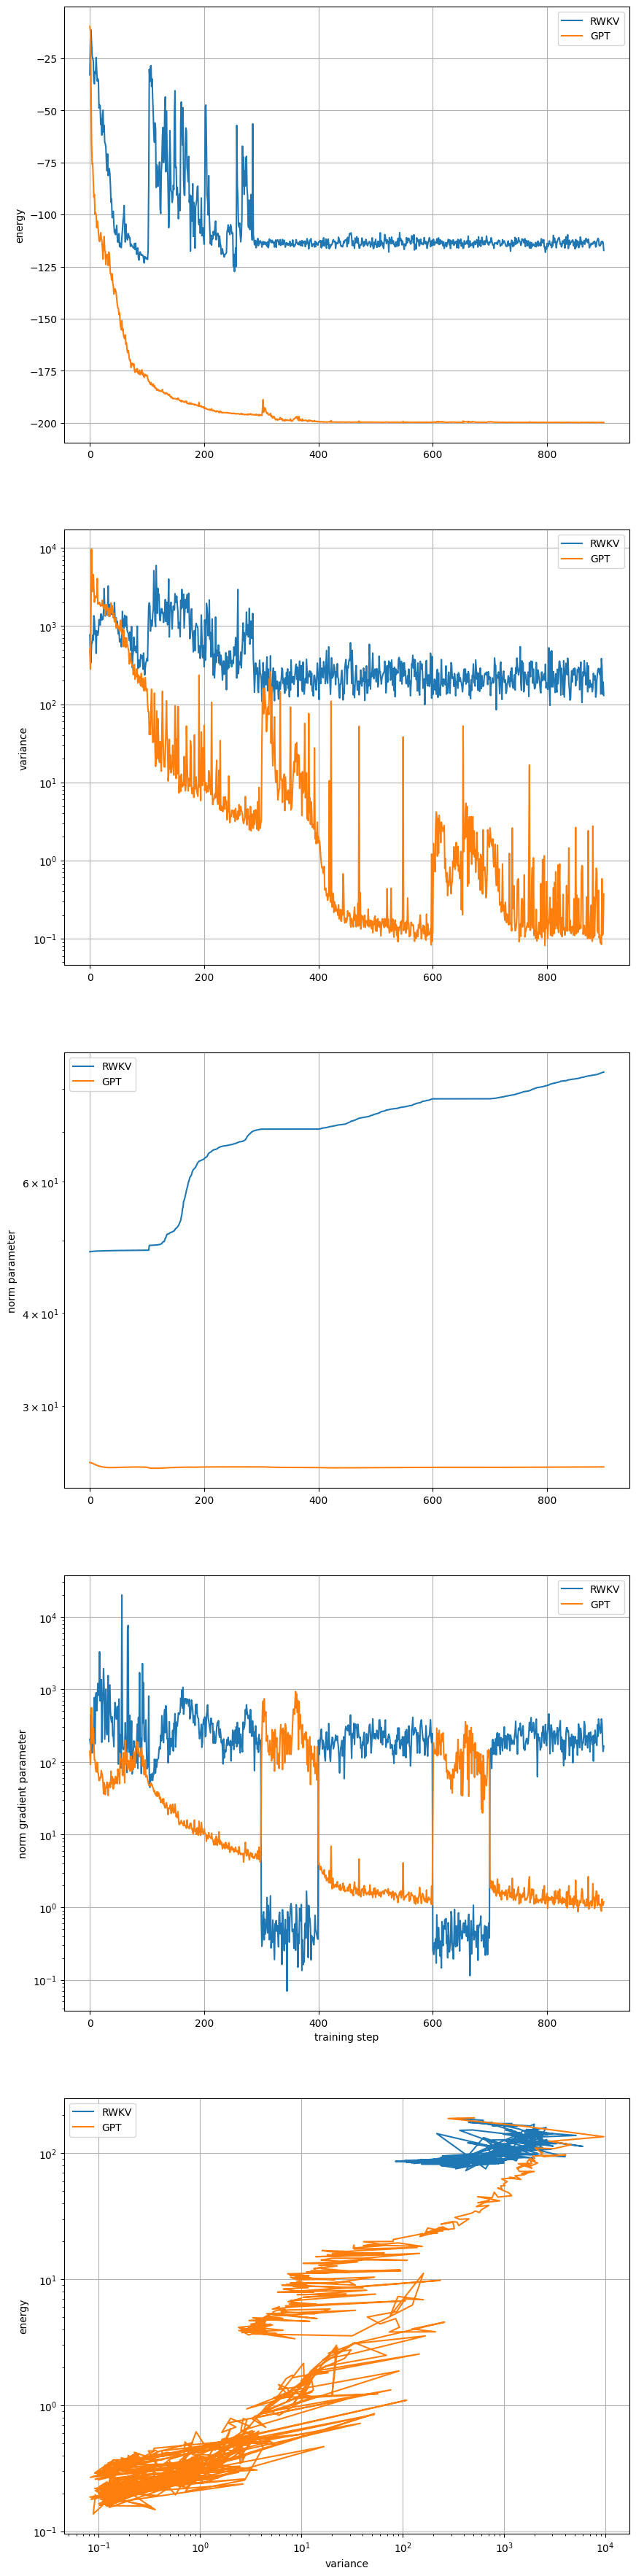

In [9]:
fig,ax = plt.subplots(5,figsize=(10,45))
ax[0].plot(resTrainingRWKV[:,0],label="RWKV")
ax[0].plot(resTrainingGPT[:,0],label="GPT")
ax[0].set_ylabel("energy")
ax[0].legend()
ax[0].grid()
ax[1].plot(resTrainingRWKV[:,1],label="RWKV")
ax[1].semilogy(resTrainingGPT[:,1],label="GPT")
ax[1].set_ylabel("variance")
ax[1].legend()
ax[1].grid()
ax[2].plot(resTrainingRWKV[:,2],label="RWKV")
ax[2].semilogy(resTrainingGPT[:,2],label="GPT")
ax[2].set_ylabel("norm parameter")
ax[2].grid()
ax[2].legend()
ax[3].plot(resTrainingRWKV[:,3],label="RWKV")
ax[3].semilogy(resTrainingGPT[:,3],label="GPT")
ax[3].set_xlabel("training step")
ax[3].grid()
ax[3].set_ylabel("norm gradient parameter")

ax[3].legend()

emin = -2*J*N
ax[4].loglog(resTrainingRWKV[:,1],np.abs(emin-resTrainingRWKV[:,0]),label="RWKV")
ax[4].loglog(resTrainingGPT[:,1],np.abs(emin-resTrainingGPT[:,0]),label="GPT")
ax[4].legend()
ax[4].set_ylabel("energy")
ax[4].set_xlabel("variance")
ax[4].grid()
plt.savefig("plot_difference_"+nameGPT+nameRWKV+".pdf")

In [10]:
import math
(math.comb(N+L-1,L-1))

45274257328051640582702088538742081937252294837706668420660

In [11]:
resTrainingGPT[:,3]

array([1.39860264e+02, 9.21961384e+01, 2.03795975e+02, 5.60650147e+02,
       2.31706284e+02, 1.80857693e+02, 2.92896756e+02, 1.99178048e+02,
       1.06755394e+02, 1.06875679e+02, 8.20322485e+01, 7.33309564e+01,
       7.29955733e+01, 9.88852266e+01, 7.24361624e+01, 6.80685291e+01,
       5.53959320e+01, 5.58715953e+01, 6.15718747e+01, 6.03952328e+01,
       7.63461699e+01, 6.95747493e+01, 6.52344296e+01, 5.22842387e+01,
       3.63424321e+01, 5.19870178e+01, 4.75287545e+01, 3.56200787e+01,
       4.46225152e+01, 4.44108385e+01, 5.28572172e+01, 4.60249468e+01,
       3.45536251e+01, 4.72335423e+01, 5.20338464e+01, 5.00743489e+01,
       4.44829544e+01, 7.48334775e+01, 5.02036166e+01, 6.30747152e+01,
       5.96866669e+01, 4.25780017e+01, 5.80961162e+01, 4.93230734e+01,
       5.41545124e+01, 6.33563707e+01, 5.08319224e+01, 6.09619502e+01,
       5.04107053e+01, 8.00193639e+01, 6.54457724e+01, 6.81183869e+01,
       5.01981312e+01, 1.29378650e+02, 1.06618767e+02, 1.09190859e+02,
      

In [12]:
tic = time.perf_counter()
time.sleep(1)
toc = time.perf_counter()


toc- tic

1.001139059662819